In [1]:
import pandas as pd # used to load, manipulate the data and for one-hot encoding
import numpy as np # data manipulation
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.utils import resample # for downsample the dataset
from sklearn.model_selection import train_test_split # for splitting the dataset into train and test split
from sklearn.preprocessing import scale # scale and center the data
from sklearn.svm import SVC # will make a SVM for classification
from sklearn.model_selection import GridSearchCV # will do the cross validation
from sklearn.metrics import plot_confusion_matrix # will draw the confusion matrix
from sklearn.decomposition import PCA # to perform PCA to plot the data
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, roc_curve, auc
import seaborn as sns

In [2]:
df = pd.read_csv(r'C:\Users\Dell\Desktop\OASISProject\oasis_longitudinal.csv')

In [3]:
df.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [4]:
# Since all subjects are right-handed, we will drop this column. Also, Subject ID and
# MRI ID are used for uniquely identifying the patient and have no role to play in our 
# model and so, will be dropped
df=df.drop(['Subject ID','MRI ID','Hand'],axis=1)

In [5]:
df.shape

(373, 12)

In [6]:
missing_values_count = df.isnull().sum()
missing_values_count[0:12]

Group        0
Visit        0
MR Delay     0
M/F          0
Age          0
EDUC         0
SES         19
MMSE         2
CDR          0
eTIV         0
nWBV         0
ASF          0
dtype: int64

In [7]:
# Replacing missing values in SES and MMSE with median values
df['SES'].fillna((df['SES'].median()), inplace=True)
df['MMSE'].fillna((df['MMSE'].median()), inplace=True)


In [8]:
# Converting M/F and Group coulumns to numeric data 
df['M/F'] = df['M/F'].replace(['M', 'F'], [1,0])
df['Group'] = [1 if each == "Demented" or each == "Converted" else 0 for each in df['Group']]

In [9]:
df.head()

,Group,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,0,1,0,1,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,0,2,457,1,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,1,1,0,1,75,12,2.0,23.0,0.5,1678,0.736,1.046
3,1,2,560,1,76,12,2.0,28.0,0.5,1738,0.713,1.010
4,1,3,1895,1,80,12,2.0,22.0,0.5,1698,0.701,1.034


In [10]:
correlation = df.corr()
df_corr = correlation['Group'].sort_values(ascending=False)
df_corr

Group       1.000000
CDR         0.778049
M/F         0.222146
SES         0.038870
ASF         0.032495
Age        -0.005941
eTIV       -0.042700
Visit      -0.095507
MR Delay   -0.120638
EDUC       -0.193060
nWBV       -0.311346
MMSE       -0.520553
Name: Group, dtype: float64

In [11]:
X = df.copy()
y = X.pop("Group")
discrete_features = X.dtypes == int

In [17]:
from sklearn.feature_selection import mutual_info_regression
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores

CDR         0.502181
MMSE        0.219870
nWBV        0.086070
ASF         0.075627
eTIV        0.070038
M/F         0.053482
EDUC        0.038019
Age         0.020900
SES         0.009887
MR Delay    0.002338
Visit       0.000000
Name: MI Scores, dtype: float64

Text(0.5, 1.0, 'Mutual Information Scores with respect to Group ')

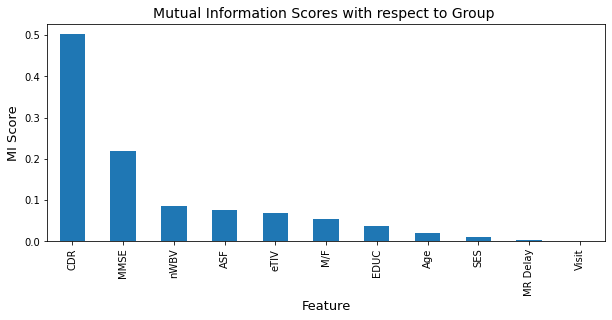

In [94]:
mi_scores.sort_values(ascending=False).plot.bar(figsize=(10, 4))
plt.ylabel('MI Score')
plt.xlabel('Feature')
axes= plt.gca()
axes.xaxis.label.set_size(13)
axes.yaxis.label.set_size(13)
axes.set_title('Mutual Information Scores with respect to Group ',fontsize=14)


In [23]:
def univariate_mul(var):
    fig = plt.figure(figsize=(8,8))
    cmap=plt.cm.Blues
    cmap1=plt.cm.coolwarm_r
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(212)
    df[var].plot(kind='hist',ax=ax1, grid=True)
    ax1.set_title('Histogram of '+var, fontsize=14)
    
    ax2=sns.distplot(df[[var]],hist=False,color='green')
    ax2.set_title('MMSE',fontsize=14,y=-0.2)
  #  ax2.title.label.set_size(15)
    ax2.yaxis.label.set_size(15)
    plt.plot(color= 'green')
    plt.show()

C:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


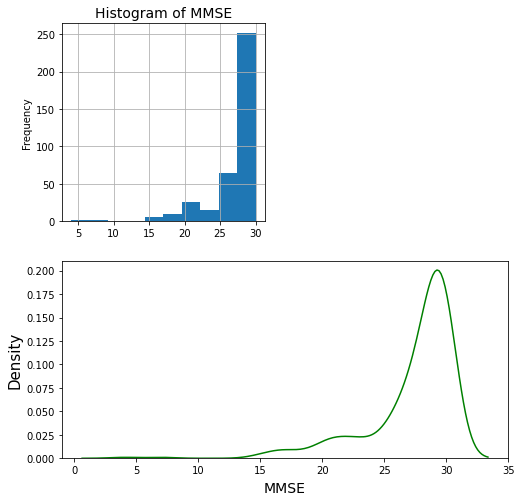

In [24]:
univariate_mul('MMSE')


(15.0, 30.0)

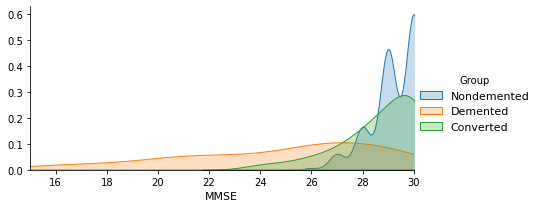

In [34]:
facet= sns.FacetGrid(df,hue="Group", aspect=2)
facet.map(sns.kdeplot,'MMSE',shade= True)
facet.set(xlim=(0, df['MMSE'].max()))
facet.add_legend(fontsize=11)
plt.xlabel('MMSE')
#plt.ylabel('Group')
axes= plt.gca()
axes.xaxis.label.set_size(11)
#axes.yaxis.label.set_size(13)
#facet.figsize(8,5)
plt.xlim([15,30])
#plt.title("MMSE score for Demented, Non-demented and Converted Adults",fontsize=13,y=-0.3)

In [12]:
 #we will drop MR delay column
df.drop(columns=['MR Delay' , 'Visit'])

,Group,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,0,1,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,0,1,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,1,1,75,12,2.0,23.0,0.5,1678,0.736,1.046
3,1,1,76,12,2.0,28.0,0.5,1738,0.713,1.010
4,1,1,80,12,2.0,22.0,0.5,1698,0.701,1.034
...,...,...,...,...,...,...,...,...,...,...
368,1,1,82,16,1.0,28.0,0.5,1693,0.694,1.037
369,1,1,86,16,1.0,26.0,0.5,1688,0.675,1.040
370,0,0,61,13,2.0,30.0,0.0,1319,0.801,1.331
371,0,0,63,13,2.0,30.0,0.0,1327,0.796,1.323


<AxesSubplot:xlabel='M/F', ylabel='CDR'>

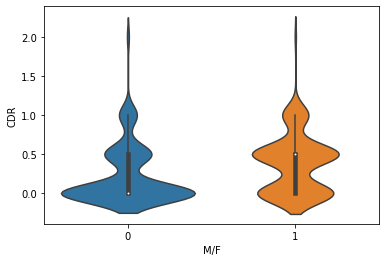

In [229]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.violinplot(x="M/F" , y="CDR",kind='swarm', data = df)

In [13]:
from sklearn.model_selection import train_test_split 
y = df['Group'].values
X = df[['M/F', 'Age', 'EDUC','MMSE', 'SES', 'eTIV', 'nWBV', 'ASF']].values


In [14]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size= 0.20, random_state=42, stratify=y)

df_ytrain = pd.DataFrame(y_trainval)
df_ytest = pd.DataFrame(y_test)

print('In Training Split:')
print(df_ytrain[0].value_counts())

print('\nIn Testing Split:')
print(df_ytest[0].value_counts())

In Training Split:
0    152
1    146
Name: 0, dtype: int64

In Testing Split:
0    38
1    37
Name: 0, dtype: int64


In [25]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
scaler = StandardScaler().fit(X_trainval)
#scaler = MinMaxScaler().fit(X_trainval)
#scaler = RobustScaler().fit(X_trainval)
X_trainval_scaled = scaler.transform(X_trainval)
X_test_scaled = scaler.transform(X_test)

In [26]:
from sklearn.svm import SVC 
clf_svm = SVC(random_state=42)
clf_svm.fit(X_trainval_scaled, y_trainval)
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, roc_curve, auc
train_score = 0
test_score = 0
test_recall = 0
test_auc = 0

train_score = clf_svm.score(X_trainval_scaled, y_trainval)
test_score = clf_svm.score(X_test_scaled, y_test)
y_predict = clf_svm.predict(X_test_scaled)
test_recall = recall_score(y_test, y_predict)
fpr, tpr, thresholds = roc_curve(y_test, y_predict)
test_auc = auc(fpr, tpr)
print("Train accuracy ", train_score)
print("Test accuracy ", test_score)
print("Test recall", test_recall)
print("Test AUC", test_auc)

Train accuracy  0.8590604026845637
Test accuracy  0.7466666666666667
Test recall 0.5945945945945946
Test AUC 0.744665718349929


In [29]:
param_grid = [

    {'C': [0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 30, 50, 80, 100],
    'gamma': ['scale', 0.5, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid']},
]

optimal_params = GridSearchCV(SVC(),
                             param_grid,
                             cv=5, # we are taking 5-fold as in k-fold cross validation
                             scoring='accuracy', # try the other scoring if have time
                             verbose=0,
                             n_jobs=-1)

optimal_params.fit(X_trainval_scaled, y_trainval)
print(optimal_params.best_params_)

{'C': 6, 'gamma': 1, 'kernel': 'rbf'}


In [30]:
C = optimal_params.best_params_['C']
gamma = optimal_params.best_params_['gamma']
kernel = optimal_params.best_params_['kernel']

In [31]:
clf_svm = SVC(random_state=42, C=C, gamma=gamma, kernel=kernel)
clf_svm.fit(X_trainval_scaled, y_trainval)

SVC(C=6, gamma=1, random_state=42)

In [32]:
train_score = 0
test_score = 0
test_recall = 0
test_auc = 0

train_score = clf_svm.score(X_trainval_scaled, y_trainval)
test_score = clf_svm.score(X_test_scaled, y_test)
y_predict = clf_svm.predict(X_test_scaled)

test_recall = recall_score(y_test, y_predict)
svm_fpr, svm_tpr, thresholds = roc_curve(y_test, y_predict)
test_auc = auc(svm_fpr, svm_tpr)

print("Train accuracy ", train_score)
print("Test accuracy ", test_score)
print("Test recall", test_recall)
print("Test AUC", test_auc)

Train accuracy  1.0
Test accuracy  0.92
Test recall 0.918918918918919
Test AUC 0.9199857752489331


In [141]:
from sklearn.tree import export_graphviz
import graphviz 
dot_data=export_graphviz(SelectedDTModel, feature_names=X_trainval.columns.values.tolist(),out_file=None)
graph = graphviz.Source(dot_data)  
graph 

NameError: name 'SelectedDTModel' is not defined

SVC : 


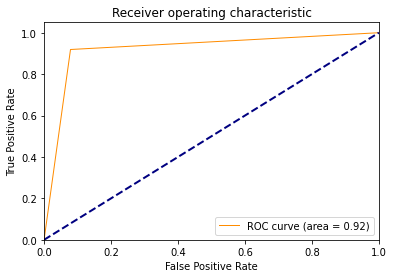


Acuuracy Of the Model:  0.92 




In [129]:
model = clf_svm
print(str(model).split('(')[0],": ")
model.fit(X_trainval_scaled,y_trainval.ravel())
X = pd.DataFrame(X_trainval_scaled)
#report_performance(model)
roc_curves(model)
accuracy(model)

In [96]:
from sklearn import metrics
def report_performance(model):
    model_test = model.predict(X_test_scaled)
    print("\n\nConfusion Matrix:")
    print("{0}".format(metrics.confusion_matrix(y_test, model_test)))
    print("\n\nClassification Report: ")
    print(metrics.classification_report(y_test, model_test))
    #cm = metrics.confusion_matrix(y_test, model_test)
    cf = confusion_matrix(y_test, model_test)
    metrics.plot_confusion_matrix(y_test, model_test)
    sns.heatmap(cf,annot=True)
report_performance(clf_svm)
sns.heatmap(cf,annot=True)



Confusion Matrix:
[[35  3]
 [ 3 34]]


Classification Report: 
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        38
           1       0.92      0.92      0.92        37

    accuracy                           0.92        75
   macro avg       0.92      0.92      0.92        75
weighted avg       0.92      0.92      0.92        75



TypeError: plot_confusion_matrix() missing 1 required positional argument: 'y_true'

In [39]:
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.model_selection import RandomizedSearchCV
n_estimators = range(10,250)
max_features = ['auto', 'sqrt']
max_depth = range(1,40)
min_samples_split = range(3,60)
parametro_rf = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split}
FOLDS =10
model_forest = RandomForestClassifier(n_jobs=-1)
forest_random = RandomizedSearchCV(estimator = model_forest, param_distributions = parametro_rf, n_iter = 100, cv = FOLDS, 
                               verbose=2, random_state=42, n_jobs = -1, scoring='neg_mean_absolute_error')
forest_random.fit(X_trainval_scaled, y_trainval)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(n_jobs=-1),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': range(1, 40),
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': range(3, 60),
                                        'n_estimators': range(10, 250)},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=2)

In [212]:
forest_random.best_params_

{'n_estimators': 46,
 'min_samples_split': 3,
 'max_features': 'sqrt',
 'max_depth': 20}

In [40]:
model_rf = forest_random.best_estimator_
model_rf =  RandomForestClassifier(n_estimators=46,min_samples_split=3,max_features='sqrt',max_depth= 20)
model_rf.fit(X_trainval_scaled,y_trainval)

RandomForestClassifier(max_depth=20, max_features='sqrt', min_samples_split=3,
                       n_estimators=46)

In [76]:
Predicted_rf= model_rf.predict(X_test_scaled)
test_recall = recall_score(y_test, Predicted_rf, pos_label=1)
fpr, tpr, thresholds = roc_curve(y_test, Predicted_rf, pos_label=1)
test_auc = auc(fpr, tpr)

In [136]:
test_score = cross_val_score(model_rf, X_trainval_scaled, y_trainval, cv=FOLDS, scoring='accuracy').mean() # Get recall for each parameter setting
test_recall = recall_score(y_test, Predicted_rf, pos_label=1)
fpr, tpr, thresholds = roc_curve(y_test, Predicted_rf, pos_label=1)
test_auc = auc(fpr, tpr)
#acc.append([model,test_score, test_recall, test_auc])
#print(acc)
#print("Train accuracy ", train_score)
print("Test accuracy ", test_score)
print("Test recall", test_recall)
print("Test AUC", test_auc)

Test accuracy  0.852183908045977
Test recall 0.7027027027027027
Test AUC 0.7855618776671409


RandomForestClassifier : 


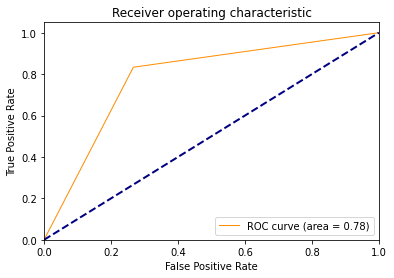


Acuuracy Of the Model:  0.7733333333333333 




In [135]:
model = RandomForestClassifier()
print(str(model).split('(')[0],": ")
model.fit(X_trainval_scaled,y_trainval.ravel())
X = pd.DataFrame(X_trainval_scaled)
#report_performance(model)
roc_curves(model)
accuracy(model)

In [128]:
from sklearn import metrics
def report_performance(model):
    model_test = model.predict(X_test_scaled)
    print("\n\nConfusion Matrix:")
    print("{0}".format(metrics.confusion_matrix(y_test, model_test)))
    print("\n\nClassification Report: ")
    print(metrics.classification_report(y_test, model_test))
    #cm = metrics.confusion_matrix(y_test, model_test)
    metrics.plot_confusion_matrix(y_test, model_test)
report_performance(model_rf) 



Confusion Matrix:
[[33  5]
 [11 26]]


Classification Report: 
              precision    recall  f1-score   support

           0       0.75      0.87      0.80        38
           1       0.84      0.70      0.76        37

    accuracy                           0.79        75
   macro avg       0.79      0.79      0.78        75
weighted avg       0.79      0.79      0.79        75



TypeError: plot_confusion_matrix() missing 1 required positional argument: 'y_true'

ExtraTreesClassifier : 


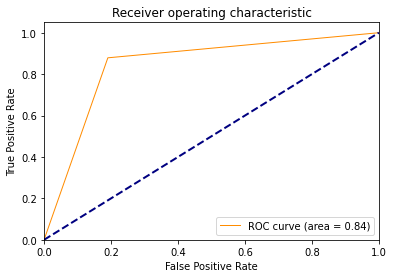

TypeError: Expected sequence or array-like, got <class 'sklearn.ensemble._forest.ExtraTreesClassifier'>

In [137]:
#from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
total_accuracy = {}
def accuracy(model):
    pred = model.predict(X_test_scaled)
    accu = metrics.accuracy_score(y_test,pred)
    print("\nAcuuracy Of the Model: ",accu,"\n\n")
    total_accuracy[str((str(model).split('(')[0]))] = accu
    
total_fpr = {}
total_tpr = {}
def roc_curves(model):
    predictions_test = model.predict(X_test_scaled)
    fpr, tpr, thresholds = roc_curve(predictions_test,y_test)
    roc_auc = auc(fpr, tpr)
    total_fpr[str((str(model).split('(')[0]))] = fpr
    total_tpr[str((str(model).split('(')[0]))] = tpr
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import ExtraTreeClassifier
model = ExtraTreesClassifier()
print(str(model).split('(')[0],": ")
model.fit(X_trainval_scaled,y_trainval.ravel())
X = pd.DataFrame(X_trainval_scaled)
#report_performance(model)
roc_curves(model)
test_recall = recall_score(y_test, model, pos_label=1)
print("Test recall", test_recall)
accuracy(model)

In [120]:
from sklearn import metrics
def plot_confusion_metrix(y_test,model_test):
    cm = metrics.confusion_matrix(y_test, model_test)
    plt.figure(1)
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Nondemented','Demented']
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.show()

In [121]:
from sklearn import metrics
def report_performance(model):
    model_test = model.predict(X_test_scaled)
    print("\n\nConfusion Matrix:")
    print("{0}".format(metrics.confusion_matrix(y_test, model_test)))
    print("\n\nClassification Report: ")
    print(metrics.classification_report(y_test, model_test))
    #cm = metrics.confusion_matrix(y_test, model_test)
    plot_confusion_matrix(y_test, model_test)
report_performance(model) 



Confusion Matrix:
[[35  3]
 [10 27]]


Classification Report: 
              precision    recall  f1-score   support

           0       0.78      0.92      0.84        38
           1       0.90      0.73      0.81        37

    accuracy                           0.83        75
   macro avg       0.84      0.83      0.82        75
weighted avg       0.84      0.83      0.82        75



TypeError: plot_confusion_matrix() missing 1 required positional argument: 'y_true'

In [16]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [27]:
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=32),
                               activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='mean_absolute_error',
        metrics=['mean_absolute_error'])
    return model

In [28]:
tuner = RandomSearch(
    build_model,
    objective='val_mean_absolute_error',
    max_trials=5,
    executions_per_trial=3,
    directory='project',
    project_name='Dementia')

INFO:tensorflow:Reloading Oracle from existing project project\Dementia\oracle.json
INFO:tensorflow:Reloading Tuner from project\Dementia\tuner0.json


In [29]:
tuner.search_space_summary()

Search space summary
Default search space size: 22
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_4 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_5 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_6 (Int)
{'default': None, 'co

In [30]:
tuner.search(X_trainval_scaled, y_trainval,
             epochs=5,
             validation_data=(X_test_scaled, y_test))

INFO:tensorflow:Oracle triggered exit


In [31]:
tuner.results_summary()

Results summary
Results in project\Dementia
Showing 10 best trials
Objective(name='val_mean_absolute_error', direction='min')
Trial summary
Hyperparameters:
num_layers: 3
units_0: 128
units_1: 288
learning_rate: 0.001
units_2: 128
units_3: 384
units_4: 96
units_5: 32
units_6: 128
units_7: 352
units_8: 352
units_9: 256
units_10: 192
units_11: 256
units_12: 224
units_13: 352
units_14: 160
units_15: 512
units_16: 416
units_17: 128
units_18: 32
units_19: 512
Score: 0.29355305433273315
Trial summary
Hyperparameters:
num_layers: 8
units_0: 480
units_1: 288
learning_rate: 0.01
units_2: 192
units_3: 256
units_4: 224
units_5: 64
units_6: 96
units_7: 288
units_8: 96
units_9: 256
units_10: 416
units_11: 128
units_12: 32
units_13: 32
units_14: 256
units_15: 320
units_16: 480
units_17: 384
units_18: 224
units_19: 480
Score: 0.30615828434626263
Trial summary
Hyperparameters:
num_layers: 16
units_0: 224
units_1: 416
learning_rate: 0.001
units_2: 384
units_3: 96
units_4: 480
units_5: 256
units_6: 416


In [395]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
model = keras.Sequential([
    keras.layers.Dense(128,input_shape=(8,),activation='relu'),
    keras.layers.Dense(288,activation='relu'),
    keras.layers.Dense(1,activation='sigmoid'),
]
)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history=model.fit(X_trainval_scaled, y_trainval,epochs=100,batch_size=5,validation_data=(X_test_scaled, y_test))

Epoch 1/100
60/60 [==============================] - 1s 4ms/step - loss: 0.5672 - accuracy: 0.7191 - val_loss: 0.4845 - val_accuracy: 0.7467
Epoch 2/100
60/60 [==============================] - 0s 2ms/step - loss: 0.4400 - accuracy: 0.7715 - val_loss: 0.4470 - val_accuracy: 0.7600
Epoch 3/100
60/60 [==============================] - 0s 2ms/step - loss: 0.3457 - accuracy: 0.8447 - val_loss: 0.4164 - val_accuracy: 0.7733
Epoch 4/100
60/60 [==============================] - 0s 2ms/step - loss: 0.3209 - accuracy: 0.8552 - val_loss: 0.4603 - val_accuracy: 0.7067
Epoch 5/100
60/60 [==============================] - 0s 2ms/step - loss: 0.3084 - accuracy: 0.8536 - val_loss: 0.4269 - val_accuracy: 0.7733
Epoch 6/100
60/60 [==============================] - 0s 3ms/step - loss: 0.2758 - accuracy: 0.8984 - val_loss: 0.4359 - val_accuracy: 0.8000
Epoch 7/100
60/60 [==============================] - 0s 3ms/step - loss: 0.2700 - accuracy: 0.8748 - val_loss: 0.5109 - val_accuracy: 0.7467
Epoch 8/100
6

In [396]:
model.evaluate(X_test_scaled,y_test)

3/3 [==============================] - 0s 2ms/step - loss: 0.3005 - accuracy: 0.8933


[0.3004736602306366, 0.8933333158493042]

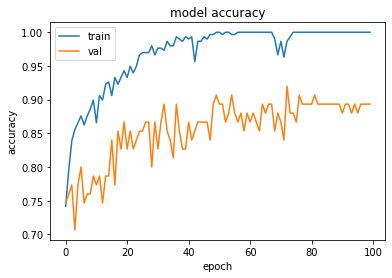

In [397]:
#import keras
#from matplotlib import pyplot as plt
#history = model.fit(X_trainval_scaled, y_trainval,validation_split = 0.2, epochs=100, batch_size=10)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


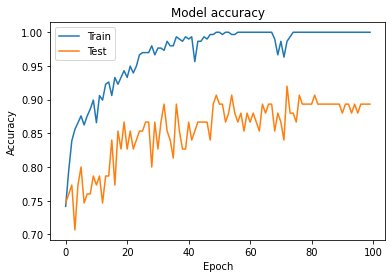

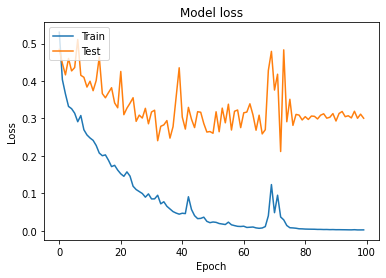

In [398]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()